### Crocks an clocks classification task

#### Выполнил: Вячеслав Гусев(Gusev Vyacheslav)

Идея:  сделаем признаковое описание для каждой картинки с помощью нейронной сети, построенной на основе структуры VGG19. Будем использовать веса VGG19, уже обученной на ImageNET. Дальше мы будем пропускать картинку через свёрточную сеть пока не получим достатчно маленькое представление, а потом будем использовать это представление в качестве признаков для обучения нашего алгоритма.

Результат и вывод будет в конце.

Задачи:
<font size="3" color="black" > <input type="checkbox" name="tasks" value= "" /> <font size="2"> Вычесть среднее из картинки </font> <br/> </font>
<font size="3" color="black" > <input type="checkbox" name="tasks" value= "" /> <font size="2"> RGB -> BGR </font> <br/> </font>

#### 1. Приведем имена картинок к удобному формату.

Напишем скрипт, которые изменит имена картинок
на более удобные для дальнейшей работы.
Скрипт будет приложен вместе с основным решением.

In [1]:
!ls

CCClassification.ipynb VGG19_cpu.py           crocodiles
Tests.ipynb            clocks                 vgg19.pkl
VGG19.pyc              clocks&crocs.zip


In [2]:
#посмотрим сколько у нас объектов
!ls crocodiles | wc -l
!ls clocks | wc -l

     501
     501


In [8]:
#запускаем скрипт
!fish clocks/change_names.fish

In [4]:
!fish crocodiles/change_names.fish

In [5]:
#посмотрим на вид наших файлов
#например имена крокодильчиков
!ls crocodiles/ | head -n 4

change_names.fish
croco0.png
croco1.png
croco10.png


####  2. Посмотрим на картинки и сделаем предобработку.

In [6]:
import os
import re
import numpy as np
import skimage.transform
from scipy import ndimage
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [9]:
#среднее по всем картинкам из ImageNET.
#взято из статьи о VGG19.
MEAN_VGG = np.array([103.939, 116.779, 123.68]).reshape((1,1,3))

In [8]:
#выкачаем имена файлов
clock_files = os.listdir("clocks")
croco_files = os.listdir("crocodiles")

In [9]:
#удалим скрипт
del clock_files[0]
del croco_files[0]

In [10]:
#отсортируем для удобства имена файлов
sorter = lambda fname: int(re.findall(r'\d+', fname)[0])
clock_files.sort(key = sorter)
croco_files.sort(key = sorter)
print clock_files[:10]
print len(clock_files), len(croco_files)

['clock0.png', 'clock1.png', 'clock2.png', 'clock3.png', 'clock4.png', 'clock5.png', 'clock6.png', 'clock7.png', 'clock8.png', 'clock9.png']
500 500


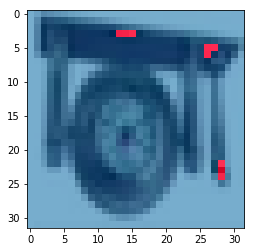

In [11]:
#потестируем преобразования
im_tt = plt.imread("clocks/" + clock_files[0])
im_tt = np.roll(im_tt, 1, axis=-1)
im_tt = im_tt[::-1, :, :]
im_tt = im_tt - MEAN_VGG
plt.imshow(im_tt)

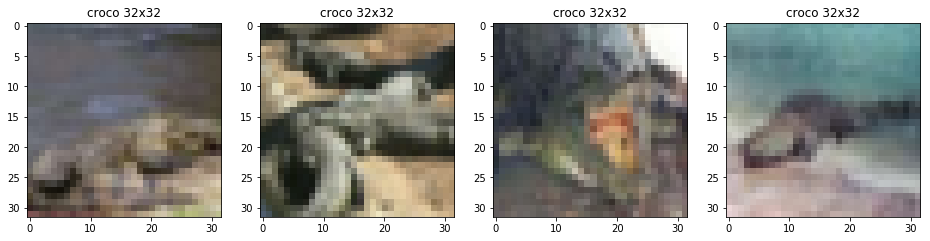

In [12]:
#покажем пару крокодильчиков
figsize(16,8)
for i in range(4):
    plt.subplot(1,4,i+1)
    im = plt.imread("crocodiles/" + croco_files[i])
    plt.title('croco %dx%d' % (im.shape[0], im.shape[1]))
    plt.imshow(im)

Будем использовать предобученную VGG19, поэтому нужно преобразовать фотографии к нужному формату.
Идеально привести к такому формату, на котормо обучалась VGG19.

In [13]:
#функция, что приводить картинки к нужному формату
def process_image(image):
    #какие результирующие размеры хотим подавать на вход VGG19
    #потому что она обучалась на таких картинках
    res_wh = 224
    image = skimage.transform.resize(image, (res_wh, res_wh), mode = 'reflect')
    image = image[::-1, :, :]
    image = image - MEAN_VGG
    return image

#### 3. Настраиваем предобученную сеть VGG19.

Скачаем веса для VGG19

In [15]:
!curl -O https://s3.amazonaws.com/lasagne/recipes/pretrained/imagenet/vgg19.pkl

Архитектура VGG19 реализована в файле VGG19_cpu.py.
В этом же файле находится функция, которая наливает веса в сеть.

In [16]:
import tensorflow as tf
import VGG19_cpu
import pickle

In [17]:
!ls

CCClassification.ipynb VGG19_cpu.py           clocks&crocs.zip
Tests.ipynb            VGG19_cpu.pyc          crocodiles
VGG19.pyc              clocks                 vgg19.pkl


In [18]:
#загружаем веса пикельные
with open('vgg19.pkl', 'r') as thefile:
    vgg_weights = pickle.loads(thefile.read())

In [10]:
#Ради интереса попробуем построить сеть и посмотреть веса её.
#tf.reset_default_graph()
#with tf.device('/gpu:0') as device:
    #задаем картинки
#    images = tf.placeholder(dtype=tf.float32, shape = [None, 3, 224, 224])
    #это предсказания для картинок? весов нету
#    preds = VGG19.inference(images)
    #задаем веса сети
#    assign_ops = VGG19.assign_weights(preds.graph.get_collection('trainable_variables'), vgg_weights['param values'])
#    init = tf.global_variables_initializer()'''

In [11]:
#Ради интереса посмотрим количество параметров в нашей сети
#print 'Number of parametrs:', len(preds.graph.get_collection("trainable_variables"))
#i = 0
#for v in preds.graph.get_collection('trainable_variables'):
#    print i, v.name, map(lambda i: i.value, v.get_shape())
#    i += 1

Потестировали VGG19, теперь займемся нашей задачей. 

А именно будем прогонять картинки через сеть и снимать признаковое описание картинок
после первого полносвязного слоя.

In [12]:
#данные в сеть подаются батчами
#создаем генератор, чтобы оптимально было хранить данные
def get_batches(X, batch_size):
    n = batch_size
    for i in xrange(0, X.shape[0], n):
        yield X[i: i+n]

In [22]:
#X_tt = np.random.random((10,3))
#batches = get_batches(X_tt,4)

In [23]:
#инциализируем картинками, которые еще и обрабатываются
clocks = np.zeros([500, 224, 224, 3])
crocs = np.zeros([500, 224, 224, 3])
i = 0
for i in range(500):
    clocks[i,:,:,:] = process_image(plt.imread("clocks/" + clock_files[i]))
    crocs[i,:,:,:] = process_image(plt.imread("crocodiles/" + croco_files[i]))

In [24]:
#NHWC - CPU
#NCHW - GPU
def from_nhwc_to_nchw(images):
    return tf.transpose(images, [0, 3, 1, 2])

def from_nchw_to_hhwc(images):
    return tf.transpose(images, [0, 2, 3, 1])

Строим вычислительный граф, который вычисляет признаки для каждого изображения. В качестве признаков берём представление после первого полносвязного слоя.

In [25]:
tf.reset_default_graph()
#with tf.device('/gpu:0') as device:
#батчами картинок будем инициализировать
images = tf.placeholder(dtype=tf.float32, shape=[None, 224, 224, 3])
#получаем фичи после первого связаного слоя
features = VGG19_cpu.dense6(images)
#инициализируем веса 
assign_op = VGG19_cpu.assign_weights(features.graph.get_collection('trainable_variables'), vgg_weights['param values'])
init = tf.global_variables_initializer()

(?, 224, 224, 3)
(?, 224, 224, 64)
(?, 112, 112, 64)
(?, 112, 112, 128)
(?, 56, 56, 128)
(?, 56, 56, 256)
(?, 56, 56, 256)
(?, 56, 56, 256)
(?, 28, 28, 256)
(?, 28, 28, 512)
(?, 28, 28, 512)
(?, 28, 28, 512)
(?, 14, 14, 512)
(?, 14, 14, 512)
(?, 14, 14, 512)
(?, 14, 14, 512)
(64, 3, 3, 3)
(3, 3, 3, 64)
(64, 64, 3, 3)
(3, 3, 64, 64)
(128, 64, 3, 3)
(3, 3, 64, 128)
(128, 128, 3, 3)
(3, 3, 128, 128)
(256, 128, 3, 3)
(3, 3, 128, 256)
(256, 256, 3, 3)
(3, 3, 256, 256)
(256, 256, 3, 3)
(3, 3, 256, 256)
(256, 256, 3, 3)
(3, 3, 256, 256)
(512, 256, 3, 3)
(3, 3, 256, 512)
(512, 512, 3, 3)
(3, 3, 512, 512)
(512, 512, 3, 3)
(3, 3, 512, 512)
(512, 512, 3, 3)
(3, 3, 512, 512)
(512, 512, 3, 3)
(3, 3, 512, 512)
(512, 512, 3, 3)
(3, 3, 512, 512)
(512, 512, 3, 3)
(3, 3, 512, 512)
(512, 512, 3, 3)
(3, 3, 512, 512)


Прогоняем граф и вычисляем признаки

In [27]:
clocks_features = []
crocs_features = []

with tf.Session() as sess:
    #переменные
    sess.run(init)
    #веса
    sess.run(assign_op)
    #прогоняем через сеть
    for im_batch in get_batches(clocks, 32):
        clocks_features.append(sess.run(features, {images:im_batch}))
    for im_batch in get_batches(crocs, 32):
        crocs_features.append(sess.run(features, {images:im_batch}))

In [28]:
clocks_features = np.concatenate(clocks_features)
crocs_features = np.concatenate(crocs_features)

#### 4. Запускаем RandomForest на полученных признаках

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import ShuffleSplit
from sklearn.metrics import roc_auc_score, accuracy_score

/usr/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [30]:
#крокодильчики будут - 1
#часы будут - 0
X = np.concatenate([clocks_features, crocs_features])
Y = np.concatenate([np.zeros(len(clocks_features)),np.ones(len(crocs_features))])

In [31]:
#проверим адекватные у нас признаки
np.all(X == 0)

False

In [34]:
#запускаем RF
ss = ShuffleSplit(len(X), n_iter=5, test_size=0.3)
for train_ids, test_ids in ss:
    rf = RandomForestClassifier(n_estimators=50)
    rf.fit(X[train_ids], Y[train_ids])
    preds = rf.predict(X[test_ids])
    probs = rf.predict_proba(X[test_ids])
    print 'ROC-AUC: %.3f, ACC: %.3f' % (roc_auc_score(Y[test_ids], probs[:,1]), accuracy_score(Y[test_ids], preds))

ROC-AUC: 0.917, ACC: 0.820
ROC-AUC: 0.943, ACC: 0.873
ROC-AUC: 0.894, ACC: 0.843
ROC-AUC: 0.937, ACC: 0.857
ROC-AUC: 0.933, ACC: 0.863


Получили очень неплохое качество. Человек в среднем ошибается в 5% случаев при классификации изображений из ImageNET. Но стоит учитывать, что наши исходные картинки пришлось растягивать, что испортило качество, думаю, что получилось очень неплохо.

Из улучшений:
1. Можно пробовать другой алгоритм обучать на признаках, например, градиентный бустинг или логистическую регрессию.
2. Пробовать другую архитектуру нейронной сети, например, ResNet.
3. Можно поробовать снять признаки после второго полносвязного слоя.

Надеюсь, что мне удалось передать основной смысл алгоритма и принцип Transfer Learning, а дальше можно пробовать различные улучшения.

##### Используемые ресурсы:
1. http://cs231n.github.io
2. https://github.com/esokolov/ml-course-hse
3. https://www.tensorflow.org/tutorials/deep_cnn
4. https://arxiv.org/pdf/1409.1556.pdf

И еще кучу статей, которые попадались в процессе чтения основных ресурсов и поиска информации.

#### Поле для творчества

In [ ]:
#def assign_weights(trainable_variables, weights_list):
#    i = 0
#    assign_ops = []
#    for v in trainable_variables:
#        w = weights_list[i]
        #if w.ndim > 2:
            #w = np.moveaxis(w, [0,1,2,3], [3, 2, 0, 1])
#        assign_ops.append(v.assign(w))
#        i += 1
#    return assign_ops

In [ ]:
#tr_vars = features.graph.get_collection('trainable_variables')
#ww = vgg_weights['param values']

In [ ]:
#tr_vars[0]